In [194]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from IPython.display import Markdown as md
from matplotlib_venn import venn3, venn2
from tracking_grants.utils.helpers import load_references, load_articles, load_metrics, load_awards, load_grants, load_trials

In [2]:
# sns.set_context("notebook")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [129]:
refs = load_references()
articles = load_articles()
metrics = load_metrics()
awards = load_awards()
trials = load_trials()
grants = load_grants()

In [157]:
# Some report-specific processing

# remove some observations from dataset
# grants = grants[grants.program!="PRORP"]
grants = grants[grants.award_amount!=0]
grants.wos_citations = grants.wos_citations.replace(0, None)

# award categories coded by Lauren
grant_cats = pd.read_excel("/home/asura/Projects/scholcommlab/tracking-grants/data/external/CDRMP_award_types.xlsx")
df = grant_cats.category.dropna().map(lambda x: [s.strip() for s in x.split("/")])
cats = grant_cats[['award type', 'publication count']].join(df.to_frame().explode("category"), how="right")
grants = grants.merge(cats[['award type', 'category']], left_on="type", right_on="award type", how="left")
grants.loc[grants.category.isna(), 'category'] = "Other"

# Tracking Grants

29.07.2020, ScholCommLab

## Part 0 - Goals/Overview

### What we hope this data can do (and what it cannot)

- Enhance the available data regarding these programs with other sources
- Provide an high-level overview of the outputs of each funding program
- Give a sense of future areas of exploration

### What we are not doing

- Not doing a detailed assessment of grants, papers, or programs
- Not evaluating the quality of the work, efficiency of the programs, of measuring if they are meeting their stated objectives. 
- Citations ≠ quality, Altmetrics ≠ public value, News ≠ saliency

## Part 1 - Data Gathering and Enhancement

### Overview of the data pipeline

![](tracking_grants_flowchart.png)

In [12]:
def plot_awards_pubs_over_years():
    df = articles.drop_duplicates("DOI").created.value_counts().to_frame("Publications")
    df['Awards'] = awards.award_year.value_counts()
    df.index.name = "Year"
    df = df.reset_index().melt(id_vars="Year", value_name="Count", var_name="Type")
    sns.barplot(x="Year", y="Count", hue="Type", data=df)
    plt.savefig("plot_awards_pubs_over_years.png")
    plt.close()
    
plot_awards_pubs_over_years()

### Overall descriptives

In [206]:
articles.program.value_counts().to_frame("Articles")

,Articles
PCRP,7434
NFRP,624
PRORP,335
TSCRP,202


### Publications and awards over years

![plot_awards_pubs_over_years.png](plot_awards_pubs_over_years.png)

In [224]:
def venn_refs():
    all_articles = set(refs.reference_id.unique().tolist())
    articles_w_altm = set(articles.reference_id.unique().tolist())

    total = len(all_articles)

    v = venn2([all_articles, articles_w_altm],
          set_labels=('', ''),
          subset_label_formatter=lambda x: "{:,} ({:.1f}%)".format(x, 100*x/total));

    v.get_patch_by_id('10').set_color(cp3[0])
    v.get_patch_by_id('11').set_color(np.add(cp3[0], cp3[1])/2)
#     v.get_patch_by_id('001').set_color(np.add(cp3[0], cp3[2])/2)
#     v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

    for text in v.set_labels:
        text.set_fontsize(10)
    # for text in v.subset_labels:
    #     text.set_fontsize(12)

    handles = []
    labels=["Total references", "Found in Crossref"]
    for l, c in zip(labels, [cp3[0], np.add(cp3[0], cp3[1])/2, np.add(cp3[0], cp3[2])/2]):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles);
    plt.savefig("venn_refs.png")
    plt.close()
    
venn_refs()

### Reference matching

In [225]:
s = f"""
- Total number of references: {len(refs)}
- References that were found in Crossref: {articles.reference_id.nunique()}
- These references were matched to {articles.DOI.nunique()} articles
"""
md(s)


- Total number of references: 9525
- References that were found in Crossref: 8595
- These references were matched to 7289 articles


### Coverage of references found in Crossref

![venn_refs.png](venn_refs.png)

In [14]:
def venn_metrics():
    all_articles = set(articles.DOI.unique().tolist())
    articles_w_altm = set(metrics[metrics.twitter_accounts.notna()].DOI.unique().tolist())
    articles_w_cit = set(metrics[metrics.wos_citations.notna()].DOI.unique().tolist())

    total = len(all_articles)

    v = venn3([all_articles, articles_w_altm, articles_w_cit],
          set_labels=('', '', ''),
          subset_label_formatter=lambda x: "{:,} ({:.1f}%)".format(x, 100*x/total));

    v.get_patch_by_id('100').set_color(cp3[0])
    v.get_patch_by_id('110').set_color(np.add(cp3[0], cp3[1])/2)
    v.get_patch_by_id('101').set_color(np.add(cp3[0], cp3[2])/2)
    v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

    for text in v.set_labels:
        text.set_fontsize(10)
    # for text in v.subset_labels:
    #     text.set_fontsize(12)

    handles = []
    labels=["Articles found", "WoS", "Twitter"]
    for l, c in zip(labels, [cp3[0], np.add(cp3[0], cp3[1])/2, np.add(cp3[0], cp3[2])/2]):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles);
    plt.savefig("venn_metrics.png")
    plt.close()
    
venn_metrics()

### Coverage of DOIs (n=7289) in the WoS and Twitter

![venn_metrics.png](venn_metrics.png)

In [15]:
def clinical_trials():
    col_order = ["Early Phase 1", "Phase 1", "Phase 2", "Phase 3", "Phase 4", "Not Applicable"]
    trials.Phase.value_counts().reindex(col_order[::-1]).plot(kind="barh")
#     plt.xticks(rotation=90)
    plt.savefig("clinical_trials.png")
    plt.close()
    
clinical_trials()

### Clinical Trials

In [230]:
s = f"""We found **{len(trials)} clinical trials** via clinicaltrials.gov.

These trials were associated with {trials.doi.nunique()} articles in our dataset funded by **{articles[articles.DOI.isin(trials.doi)].grant_id.nunique()} grants**.
"""
md(s)

We found **301 clinical trials** via clinicaltrials.gov.

These trials were associated with 231 articles in our dataset funded by **182 grants**.


#### Breakdown of trials (n=301) by phases

![clinical_trials.png](clinical_trials.png)

## Part 2 - Data on the grant level

#### Number of awards per program

In [239]:
grants.drop_duplicates("grant_id").program.value_counts().to_frame("Awards")

,Awards
PCRP,1976
NFRP,186
PRORP,95
TSCRP,85


In [250]:
def pubs_per_grant():    
    df = grants[['grant_id', 'program', 'award_amount', 'n_dois']].copy()
    df = df.drop_duplicates()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="n_dois", x="program", data=df)
    plt.yscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100, 200]
    plt.yticks(ticks, ticks);
    plt.xlabel("Research programs")
    plt.ylabel("Publications per grant");
    plt.tight_layout()
    plt.savefig("pubs_per_grant.png")
    plt.close()
    
pubs_per_grant()

### Number of publications per grant program

![pubs_per_grant.png](pubs_per_grant.png)

In [251]:
def dollars_per_grant():    
    df = grants[['grant_id', 'program', 'award_amount', 'n_dois']].copy()
    df = df.drop_duplicates()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="award_amount", x="program", data=df)
    plt.yscale("log")
    ticks = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    plt.yticks(ticks, ticks);
    plt.xlabel("Research programs")
    plt.ylabel("Award amount in $ (millions)");
    plt.tight_layout()
    plt.savefig("dollars_per_grant.png")
    plt.close()
    
dollars_per_grant()

### Award amount per grant program

![dollars_per_grant.png](dollars_per_grant.png)

In [252]:
def grant_percentiles(metric, label, log=False, program=None):
    df = grants[grants.category.notna()]
    df = df.drop_duplicates("grant_id")
    df = df[df.category!="Consortium"]
    if program:
        df = df[df.program==program]
    
    award_90th = df.award_amount.quantile(.9)
    award_99th = df.award_amount.quantile(.99)
    
    metric_90th = df[metric].quantile(.9)
    metric_99th = df[metric].quantile(.99)
    
    sns.lmplot(x="award_amount", y=metric, hue="category", data=df, height=8, aspect=1.4, fit_reg=False, scatter_kws={'alpha':.7})

    plt.hlines(metric_90th, 0, award_90th, linestyles="--")
    plt.hlines(metric_99th, 0, award_99th, linestyles="--")

    plt.vlines(award_90th, 0, metric_90th, linestyles="--")
    plt.vlines(award_99th, 0, metric_99th, linestyles="--")

    plt.text(-.3, metric_90th, "90th", fontdict={'size':12});
    plt.text(-.3, metric_99th, "99th", fontdict={'size':12});
    
    if log:
        plt.yscale("log")
    
    plt.ylabel(label)
    plt.xlabel("Size of award in $ (millions)")
    plt.tight_layout()
    plt.savefig("grant_percentiles.png")
    plt.close()
    
grant_percentiles("n_dois", "Number of Publications", program=None)

### Award size vs number of publications (without Consortia Awards)

![grant_percentiles.png](grant_percentiles.png)

In [254]:
def award_types():    
    df = grants[['program', 'category', 'award_amount', 'n_dois']].copy()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="award_amount", x="program", hue="category", data=df)
    plt.yscale("log")
    ticks = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    plt.yticks(ticks, ticks);
    plt.xlabel("Research programs")
    plt.ylabel("Award amount in $ (millions)");
    plt.tight_layout()
    plt.savefig("dollars_per_award_type.png")
    plt.close()
    
    sns.boxenplot(y="n_dois", x="program", hue="category", data=df)
    plt.yscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100]
    plt.yticks(ticks, ticks)
    plt.xlabel("Research programs")
    plt.ylabel("Number of publications");
    plt.tight_layout()
    plt.savefig("pubs_per_award_type.png")
    plt.close()
    
award_types()

### Number of publication by award types

![pubs_per_award_type.png](pubs_per_award_type.png)

### Award amount by award types

![dollars_per_award_type.png](dollars_per_award_type.png)

## Part 3 - Not all grants are the same

In [260]:
def plot_metrics(cols):
    df = grants.drop_duplicates("grant_id")[cols]
    df = df.melt(id_vars="program", var_name="Metric", value_name="Count")
    # sns.boxplot(x="Metric", y="Count", data=df)
    sns.boxenplot(x="Metric", y="Count", hue="program", data=df)
    plt.yscale("log")
    ticks = [1, 2, 5, 10, 100, 1000, 2000]
    plt.yticks(ticks, ticks);
    plt.xticks(rotation=30, ha="right")
    plt.xlabel("Metrics")
    plt.ylabel("Counts");
    plt.tight_layout()
    plt.savefig("metrics.png")
    plt.close()
    
cols = ['program', 'wos_citations', 'twitter_accounts', 'patents', 'news_outlets', 'blogs', 'fb_pages',
       'videos', 'reddit_threads', 'policies', 'wikipedia', 'n_trials', 'n_dois',]
plot_metrics(cols)

### Measuring grant outputs

![metrics.png](metrics.png)

In [267]:
def pairplots():
    df = grants[['wos_citations', 'twitter_accounts', 'news_outlets', 'category']].copy()
    sns.pairplot(data=df, hue="category", diag_kind="kde", )
#     plt.tight_layout()
    plt.savefig("pairplots.png")
    plt.close()
    
pairplots()

### Pairplot on the grant level

![pairplots.png](pairplots.png)

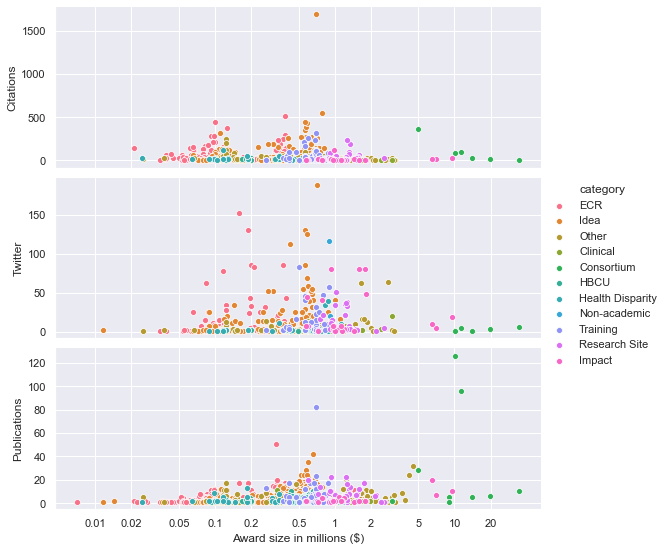

In [266]:
def outputs_per_dollars():
    df = grants[['wos_citations', 'twitter_accounts', 'n_dois', 'category', 'award_amount']].copy()

    df.columns = ["Citations", "Twitter", "Publications", "category", "award_amount"]
    sns.pairplot(df, x_vars="award_amount", y_vars=["Citations", 'Twitter', 'Publications'], hue="category", aspect=3)
    plt.xscale("log")
    ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    plt.xticks(ticks, ticks);
    plt.xlabel("Award size in millions ($)");
#     plt.tight_layout()
    plt.savefig("outputs_per_dollars.png")
#     plt.close()
    
outputs_per_dollars()

### Outputs over award size

![outputs_per_dollars.png](outputs_per_dollars.png)

## Part 5 - Limitations

### Data quality and completeness

- We are not fetching papers, only using data provided
- We are matching citation strings to Crossref database: there’s an error rate in this matching
- Citations from WoS only count citing papers from other WoS papers
- Altmetric and Unpaywall are also known to have some errors (as with any database drawn from searching the Web).